Random Forest Accuracy: 0.9207 
───────────────────────────────

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.33      0.50        21
           B       0.80      0.87      0.83        54
           C       0.95      0.92      0.94        78
           D       0.91      0.89      0.90        83
           F       0.94      0.99      0.97       243

    accuracy                           0.92       479
   macro avg       0.92      0.80      0.83       479
weighted avg       0.92      0.92      0.91       479



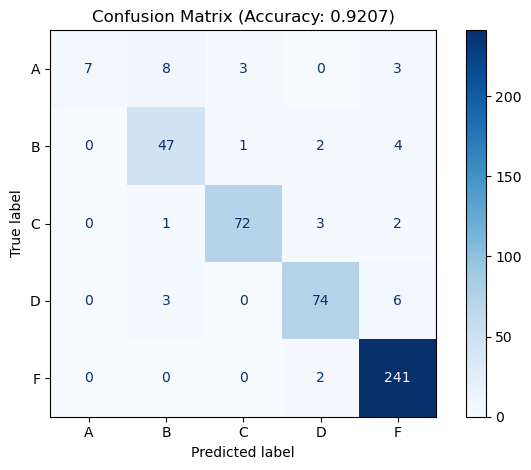

First 20 Predictions:


,StudentID,GradeClass,Predicted,ActualGrade,PredictedGrade,Match
0,2594,4.000000,4,F,F,True
1,2832,4.000000,4,F,F,True
2,2568,4.000000,4,F,F,True
3,2203,4.000000,4,F,F,True
4,1674,4.000000,4,F,F,True
5,1577,4.000000,4,F,F,True
6,2484,4.000000,4,F,F,True
7,1297,1.000000,1,B,B,True
8,2320,4.000000,4,F,F,True
9,2026,4.000000,4,F,F,True


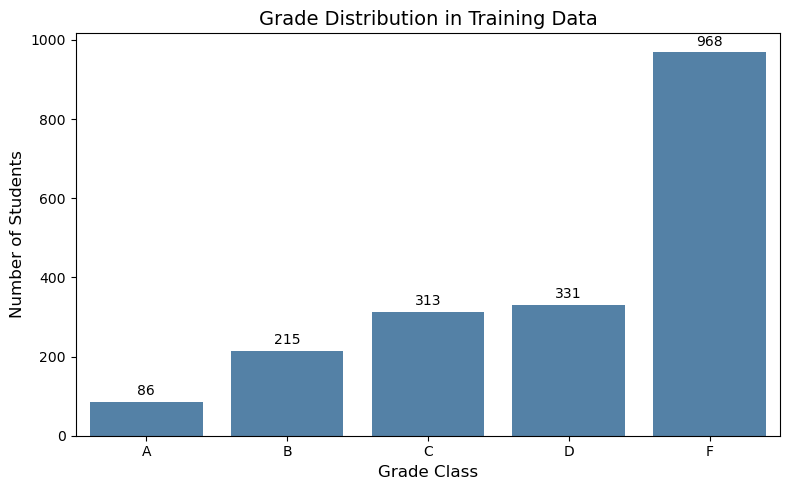

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import pickle
import os
import warnings

#Load your data
train_data = pd.read_csv("../Data/train_data.csv")
test_data = pd.read_csv("../Data/test_data.csv")

#Separate features and labels
X_train = train_data.drop(columns=["GradeClass", "StudentID"])
y_train = train_data["GradeClass"].astype(int)

X_test = test_data.drop(columns=["GradeClass", "StudentID"])
y_test = test_data["GradeClass"].astype(int)

#Scale your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

#Make predictions
y_pred = model.predict(X_test_scaled)

#Grade mapping
grade_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'F'}
y_test_letters = pd.Series(y_test).map(grade_map)
y_pred_letters = pd.Series(y_pred).map(grade_map)
label_names = [grade_map[i] for i in sorted(grade_map)]

#Evaluation
accuracy = accuracy_score(y_test_letters, y_pred_letters)
print("Random Forest Accuracy:", round(accuracy, 4), "\n───────────────────────────────")
print("\nClassification Report:")
print(classification_report(y_test_letters, y_pred_letters, target_names=label_names, zero_division=0))

#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test_scaled,
    y_test,
    display_labels=label_names,
    cmap='Blues'
)
plt.title(f"Confusion Matrix (Accuracy: {round(accuracy, 4)})")
plt.tight_layout()
plt.show()

#Save model and scaler  
output_model_path = "../Artifacts/PLK"
os.makedirs(output_model_path, exist_ok=True)

with open(os.path.join(output_model_path, "random_forest_scaler.pkl"), "wb") as f:
    pickle.dump(model, f)

with open(os.path.join(output_model_path, "random_forest_model.pkl"), "wb") as f:
    pickle.dump(scaler, f)

#Prediction comparison table
comparison_df = test_data[["StudentID", "GradeClass"]].copy()
comparison_df["Predicted"] = y_pred
comparison_df["ActualGrade"] = comparison_df["GradeClass"].astype(int).map(grade_map)
comparison_df["PredictedGrade"] = pd.Series(y_pred).astype(int).map(grade_map)
comparison_df["Match"] = comparison_df["ActualGrade"] == comparison_df["PredictedGrade"]
comparison_df = comparison_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save prediction table
comparison_df.to_csv("../Artifacts/Predictions/prediction_results_random_forest.csv", index=False)

#Display sample
try:
    from IPython.display import display

    def highlight_false_text(row):
        styles = []
        for col in row.index:
            if col == "Match" and row["Match"] == False:
                styles.append("color: red; background-color: black")
            else:
                styles.append("background-color: black; color: white")
        return styles

    print("First 20 Predictions:")
    display(comparison_df.head(20).style.apply(highlight_false_text, axis=1))
except:
    print("\nFirst 20 Predictions:")
    print(comparison_df.head(20).to_string(index=False))

#Final Grade Distribution Plot
plt.figure(figsize=(8, 5))
grade_counts = train_data["GradeClass"].astype(int).value_counts().sort_index()
grade_labels = ['A', 'B', 'C', 'D', 'F']
sns.barplot(x=grade_labels, y=grade_counts.values, color='steelblue')
for i, count in enumerate(grade_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)
plt.title("Grade Distribution in Training Data", fontsize=14)
plt.xlabel("Grade Class", fontsize=12)
plt.ylabel("Number of Students", fontsize=12)
plt.tight_layout()
plt.show()

# Grade mapping
grade_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'F'}
y_pred_letters = pd.Series(y_pred).map(grade_map)

# Count predicted grades
predicted_counts = y_pred_letters.value_counts().reindex(['A', 'B', 'C', 'D', 'F'], fill_value=0)

# Create summary DataFrame
grade_summary_df = pd.DataFrame({
    "Grade": predicted_counts.index,
    "Count": predicted_counts.values
})

# Add total row
total_row = pd.DataFrame([{"Grade": "Total", "Count": grade_summary_df["Count"].sum()}])
grade_summary_df = pd.concat([grade_summary_df, total_row], ignore_index=True)

# Display table
print(grade_summary_df.to_string(index=False))

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(grade_summary_df["Grade"], grade_summary_df["Count"], color='skyblue')
for i, count in enumerate(grade_summary_df["Count"]):
    plt.text(i, count + 2, str(count), ha='center', va='bottom', fontsize=10)
plt.title("Predicted Grade Distribution")
plt.xlabel("Grade")
plt.ylabel("Number of Students")
plt.tight_layout()
plt.show()